<a href="https://colab.research.google.com/github/devipriyaraju/NLP_Image_Captioning_Project/blob/main/Densenet_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import cv2
from google.colab import output
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time
import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations

import warnings
warnings.filterwarnings("ignore")
import xml.etree.ElementTree as ET

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files


In [ ]:
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")


In [ ]:
#train=train.rename(columns={"impression_final": "Report_abs", "impression_op": "Report_out","impression_ip":"Report_in","impression":"Report"})

In [ ]:
#test=test.drop(["xml file name","impression_counts"],axis=1)

In [ ]:
test=test.rename(columns={"image_1": "Image1","image_2":"Image2"})

In [ ]:
token = tf.keras.preprocessing.text.Tokenizer(filters = '',oov_token = '<unk>') 
token.fit_on_texts(train.Report_abs.values)
train_cap = token.texts_to_sequences(train.Report_abs) 
test_cap = token.texts_to_sequences(test.Report_abs) 
vocab_size = len(token.word_index)

for i in train_cap:
  report_len=np.array([len(i) for i in train_cap])
ind_start = token.word_index['<cls>'] #tokened value of starting index
end_start = token.word_index['<end>'] #tokened value of end index

In [ ]:
np.percentile(report_len,80)

30.0

Most of the captions have 30 as words in it and hence we will choose this value as maximum padding value.

In [ ]:
import imgaug.augmenters as aug
from tensorflow.keras.preprocessing.text import Tokenizer
maximum_padding=30
augmentation=True
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,dataframe,input_size,tokenizer = token,maximum_padding = 30,augmentation = augmentation): 
    """
    dataframe  = dataframe containing image_1,image_2 and impression
    """
    self.img1 = dataframe.Image1
    self.input_size = input_size 
    self.img2 = dataframe.Image2
    self.augmentation = augmentation
    self.Report_in = dataframe.Report_in
    self.tokenizer = tokenizer
    self.Report_out = dataframe.Report_out 
    self.maximum_padding = maximum_padding
    self.aug1 = aug.Fliplr(1) #flip images horizaontally
    self.aug2 = aug.Sharpen(alpha=(1.0), lightness=(0.8)) #sharpens the image and apply some lightness/brighteness 1 means fully sharpened etc
    self.aug3 = aug.Flipud(1) #flip images vertically

  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    img1 = cv2.imread(self.img1[i],cv2.IMREAD_UNCHANGED)
    img2 = cv2.imread(self.img2[i],cv2.IMREAD_UNCHANGED) #here there are 3 channels
    img1=img1/255
    img2=img2/255
    img1 = cv2.resize(img1,self.input_size,interpolation = cv2.INTER_NEAREST)
    img2 = cv2.resize(img2,self.input_size,interpolation = cv2.INTER_NEAREST)
    '''if img1.any()==None:
      print("%i , %s image sent null value"%(i,self.img1[i]))
    if img2.any()==None:
      print("%i , %s image sent null value"%(i,self.img2[i]))'''


    #tokenizing and padding
    Report_in = self.tokenizer.texts_to_sequences(self.Report_in[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    Report_in = tf.keras.utils.pad_sequences(Report_in,maxlen = self.maximum_padding,padding = 'post') #opshape:(input_length,)
    Report_in = tf.squeeze(Report_in,axis=0) #opshape = (input_length,) removing unwanted axis if present

    Report_out = self.tokenizer.texts_to_sequences(self.Report_out[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    Report_out = tf.keras.utils.pad_sequences(Report_out,maxlen = self.maximum_padding,padding = 'post') #opshape: (input_length,)
    Report_out = tf.squeeze(Report_out,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.2:
              img1 = self.aug1.augment_image(img1)
              img2 = self.aug1.augment_image(img2)
          elif a<0.7:
              img1 = self.aug3.augment_image(img1)
              img2 = self.aug3.augment_image(img2)
          else: #applying no augmentation
              img1 = self.aug2.augment_image(img1)
              img2 = self.aug2.augment_image(img2)

    
    return img1,img2,Report_in,Report_out
 
  def __len__(self):
    return len(self.img1)

class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self,dataframe,batch_size=1):
        self.dataframe = dataframe
        self.shuffle = True
        self.batch_size = batch_size
        l=len(self.dataframe)
        self.length = np.arange(l)

    def __getitem__(self, i):
        
        # collect batch data
        ini = i * self.batch_size*i
        end = self.batch_size + ini
        length = [self.length[j] for j in range(ini,end)] #getting the shuffled index values
        #for j in range(ini,end):
         # length=[self.length[j]]
        dataset = [self.dataframe[j] for j in length] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        #for j in length:
         # dataset = [self.dataframe[j]]
        batches = [np.stack(samples, axis=0) for samples in zip(*dataset)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1                                                                      maximum_padding


        return tuple([[batches[0],batches[1],batches[2]],batches[3]]) #here [image1,image2, caption(without )],caption(without ) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.length) // self.batch_size
    
    def on_batch_end(self): #it runs at the end of epoch
        if self.shuffle==True:
            np.random.shuffle(self.length) #in-place shuffling takes place
     

In [ ]:
batch_size=100
input_size = (224,224)
ebd_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.1
train_dataset = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataset,batch_size = 100)


test_dataset = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataset,batch_size = 100)
     

In [ ]:
'''
#train_img_features_samp=np.zeros((7625,98,1024))
#test_img_features_samp=np.zeros((848,98,1024))

for i in (range(train.shape[0])):

    image_1=train.iloc[i]["Image1"]
    image_2=train.iloc[i]["Image2"]
    #NLMCXR_png1/CXR1000_IM-0003-1001.png
    train_img_features_samp[i]=(pre_process('NLMCXR_png1/'+image_1,'NLMCXR_png1/'+image_2,train.iloc[i]["Report_in"],train.iloc[i]["Report_out"]))
    
for i in (range(test.shape[0])):

    image_1=test.iloc[i]["Image1"]
    image_2=test.iloc[i]["Image2"]
    #NLMCXR_png1/CXR1000_IM-0003-1001.png
    print(i)
    test_img_features_samp[i]=(pre_process('NLMCXR_png1/'+image_1,'NLMCXR_png1/'+image_2,test.iloc[i]["Report_in"],test.iloc[i]["Report_out"]))
    '''

'\n#train_img_features_samp=np.zeros((7625,98,1024))\n#test_img_features_samp=np.zeros((848,98,1024))\n\nfor i in (range(train.shape[0])):\n\n    image_1=train.iloc[i]["Image1"]\n    image_2=train.iloc[i]["Image2"]\n    #NLMCXR_png1/CXR1000_IM-0003-1001.png\n    train_img_features_samp[i]=(pre_process(\'NLMCXR_png1/\'+image_1,\'NLMCXR_png1/\'+image_2,train.iloc[i]["Report_in"],train.iloc[i]["Report_out"]))\n    \nfor i in (range(test.shape[0])):\n\n    image_1=test.iloc[i]["Image1"]\n    image_2=test.iloc[i]["Image2"]\n    #NLMCXR_png1/CXR1000_IM-0003-1001.png\n    print(i)\n    test_img_features_samp[i]=(pre_process(\'NLMCXR_png1/\'+image_1,\'NLMCXR_png1/\'+image_2,test.iloc[i]["Report_in"],test.iloc[i]["Report_out"]))\n    '

In [ ]:
'''np.save("train_features_samp",train_img_features_samp)
np.save("test_features_samp",test_img_features_samp)'''

'np.save("train_features_samp",train_img_features_samp)\nnp.save("test_features_samp",test_img_features_samp)'

In [ ]:
'''train_img_features=np.load("train_features_samp.npy")
test_img_features=np.load("test_features_samp.npy") '''

'train_img_features=np.load("train_features_samp.npy")\ntest_img_features=np.load("test_features_samp.npy") '

In [ ]:
glv = {}
with open('glove.6B.300d.txt',encoding='utf-8') as file: #300 dimesions
  for i in file:
    word = i.split()
    glv[word[0]] = np.asarray(word[1:], dtype='float32')

In [ ]:
emb_dim = 300
# create a weight matrix for words in training docs for embedding purpose
emb_mat = np.zeros((vocab_size+1, emb_dim)) 

for word, i in token.word_index.items():
  vec = glv.get(word)
  if vec is not None:
      emb_mat[i] = vec[:emb_dim] #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
     

**CHexNet Model:**

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model
from tensorflow.keras.applications import DenseNet121
import tensorflow as tf


img_inp = Input(shape=(224,224,3))
base_model = DenseNet121(include_top=False,input_shape=(224,224,3))

layer0 = base_model.layers[-1].output
layer1 = tf.keras.layers.GlobalAveragePooling2D()(layer0)
layer2 = Dense(14, activation="sigmoid", name="densenet_out")(layer1)

final_model = tf.keras.Model(inputs = base_model.input, outputs=Dense(14, activation="sigmoid", name="densenet_out")(layer1))
final_model.load_weights("densenet_weights.h5")
final_model = tf.keras.Model(inputs= base_model.input, outputs= final_model.layers[-3].output)
final_model.trainable= False
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_12[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                           

**Image Encoder:**

In [ ]:
den_dim=512
emb_dim =300
lstm_units= 512
dropout_rate = 0.1
attention_units=512

In [ ]:
class Img_encoder(tf.keras.layers.Layer):  #This layer takes the input images as tensors and outputs the features extracted from the images.

  def __init__(self,name = "Img_encoder"):
    super().__init__()
    self.chexnet = final_model
    self.chexnet.trainable = False
    self.avgpool = tf.keras.layers.AveragePooling2D()
  
  def call(self,data):
    l1 = self.avgpool(self.chexnet(data))
    out = tf.reshape(l1,shape = (-1,l1.shape[1]*l1.shape[2],l1.shape[3]))
    return out 
def Encoder(img1,img2,dense_dim = den_dim,dropout_rate = dropout_rate):
  """
  Takes image1,image2
  gets the final encoded vector of these
  """
  #image1
  im_encoder = Img_encoder()
  img1_feat = im_encoder(img1) 
  func1 = tf.keras.layers.Dense(dense_dim,name = 'enc_func1',activation = 'relu') 
  img1_feat = func1(img1_feat)


  img2_feat = im_encoder(img2)
  img2_feat = func1(img2_feat)


  #combining image1 and image2
  concat = tf.keras.layers.Concatenate(axis=1)([img1_feat,img2_feat]) 
  bn = tf.keras.layers.BatchNormalization(name = "Img_encoder_bn")(concat) 
  dropout = Dropout(dropout_rate,name = "Img_encoder_do")(bn)
  return dropout
     

Attention:

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self,dense_dim = den_dim):
    super().__init__() #Initializing the variables 
    self.weight_matrix1 = tf.keras.layers.Dense(units = dense_dim) # encode_units*dense_dim
    self.weight_matrix2 = tf.keras.layers.Dense(units = dense_dim) # decode_units*dense_dim
    self.V = tf.keras.layers.Dense(units = 1) #dense_dimension *1 

  def call(self,enc_out,hidden_decode): #(None,98,dense_dim)
    hidden_decode = tf.expand_dims(hidden_decode,axis=1) #shape: (None,1,dense_dim)
    tanh_inp = self.weight_matrix1(enc_out) + self.weight_matrix2(hidden_decode) #: batch_size*98*dense_dim
    tanh_out =  tf.nn.tanh(tanh_inp)
    attention_weights = tf.nn.softmax(self.V(tanh_out),axis=1) #attention weights = softmax(tanh_out)
    out = attention_weights*enc_out   # multiply the attention weights with corresponding context vector
    convt_vec = tf.reduce_sum(out,axis=1) #reducing all the context vectors.


    return convt_vec,attention_weights

In [ ]:
max_padding=30
class Decode1(tf.keras.layers.Layer):
  
  def __init__(self,vocab_size = vocab_size, embedding_dim = 300, max_pad = max_padding, dense_dim = den_dim ,name = "decoder1"):
    # Initialize decoder ebd layer, LSTM and any other objects needed
    super().__init__()
    self.dense_dim = dense_dim
    self.ebd = tf.keras.layers.Embedding(input_dim = vocab_size+1,output_dim = embedding_dim,input_length=max_pad,weights = [emb_mat],mask_zero=True,name = 'decoder1_emb')
    self.LSTM = tf.keras.layers.GRU(units=self.dense_dim,return_state=True,name = 'decoder1_lstm')
    self.attention = Attention(dense_dim  = dense_dim)
    self.concat = tf.keras.layers.Concatenate(axis=-1)
    self.dense = Dense(dense_dim,name = 'decoder1_dense',activation = 'relu')
    self.final = Dense(vocab_size+1,activation='softmax')
    self.concat = tf.keras.layers.Concatenate(axis=-1)
    self.add =tf.keras.layers.Add()

  @tf.function
  def call(self,dec_inp, encoder_output, hidden_dec):#,decoder_c):
 
    emb_out = self.ebd(dec_inp) #batch_size*1*emb_shape
    con_vec,attention_weights = self.attention(encoder_output,hidden_dec) 
    con_vec_time = tf.expand_dims(con_vec,axis=1)
    concat_input = self.concat([con_vec_time,emb_out])#teacher forcing
    out,hidden_dec = self.LSTM(concat_input,initial_state = hidden_dec)

    out = self.final(out) #batch_size*decoder(vocab size)
    return out,hidden_dec,attention_weights
     

In [ ]:

class Decode2(tf.keras.Model):  #encoder out and caption
 
  def __init__(self,max_pad = max_padding, embedding_dim = 300,dense_dim = 512,score_fun='general',batch_size = batch_size,vocab_size = vocab_size):
    super().__init__()
    self.decode1 = Decode1(vocab_size = vocab_size, embedding_dim = ebd_dim, max_pad = max_pad, dense_dim = dense_dim)
    self.mat_out = tf.TensorArray(tf.float32,size=max_pad)
    self.dense_dim =dense_dim
    self.batch_size = batch_size
    self.max_pad = max_pad
    
  @tf.function
  def call(self,encoder_output,caption):
    hidden_decode1, _ = tf.zeros_like(encoder_output[:,0]), tf.zeros_like(encoder_output[:,0]) 
    print("decoder_h_shape",hidden_decode1.shape)
    mat_out = tf.TensorArray(tf.float32,size=30)
    for ts in range(self.max_pad): 
      output,hidden_decode1,attention_weights = self.decode1(caption[:,ts:ts+1], encoder_output, hidden_decode1)
      mat_out = mat_out.write(ts,output) #ts*batch_size*vocab_size

    self.mat_out = tf.transpose(mat_out.stack(),[1,0,2]) #Output Matrix
    return self.mat_out
     

In [ ]:
#https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
#Model
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) 
image2 = Input(shape = (input_size + (3,))) 
caption = Input(shape = (30,))

encoder_output = Encoder(image1,image2) #shape: (None,28,512)
#print(encoder_output.shape)
output = Decode2()(encoder_output,caption)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

decoder_h_shape (None, 512)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_encoder (Img_encoder)      (None, 9, 1024)      7037504     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

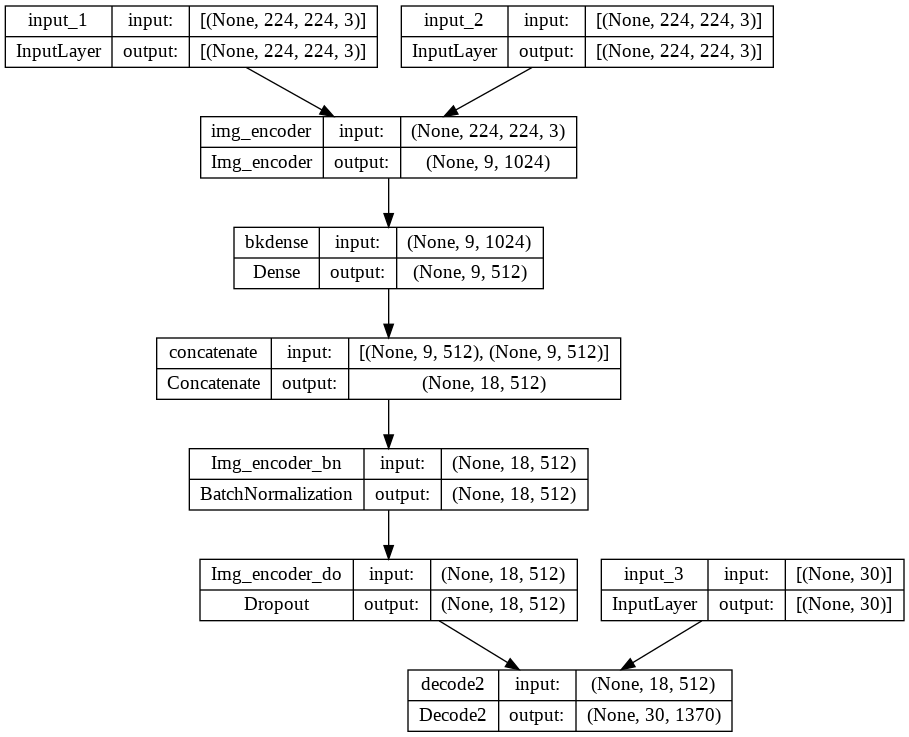

In [ ]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )
     

In [ ]:
loss_f = tf.keras.losses.SparseCategoricalCrossentropy() 
def loss_function(y_true,y_pred):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  loss1 = loss_f(y_true, y_pred)
  loss2 = loss_f(y_true, y_pred)*(tf.cast(mask, dtype=loss1.dtype))
  return tf.reduce_mean(loss2)

optimi = tf.keras.optimizers.Adam(learning_rate = 10**-2)   
model.compile(optimizer=optimi,loss=loss_function,metrics= ['accuracy'])

     


In [ ]:
#From Keras/Tensflow doc
tf.keras.backend.clear_session()
model_save = os.path.join('/content/gdrive/MyDrive/Colab Notebooks/','densenet_attention_2.h5')

dir_file = os.path.join('/content/gdrive/MyDrive/Colab Notebooks/','densenet_attention_logs')
my_callbacks = [
    tf.keras.callbacks.TensorBoard(histogram_freq=1,log_dir=dir_file),tf.keras.callbacks.EarlyStopping(patience = 7,verbose = 1,mode="min"),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,save_best_only = True,save_weights_only = True,verbose = 1,save_freq="epoch"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose = 1,patience=4, min_lr=10**-9, mode="min" )
                                   
]
     

In [ ]:
'''model.fit(train_dataloader,validation_data = test_dataloader,epochs = 10,callbacks = my_callbacks)'''

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 3.1383 - accuracy: 0.5783 
Epoch 1: val_loss improved from inf to 2.26575, saving model to /content/gdrive/MyDrive/Colab Notebooks/densenet_attention_2.h5
44/44 [==============================] - 2541s 56s/step - loss: 3.1383 - accuracy: 0.5783 - val_loss: 2.2657 - val_accuracy: 0.7236 - lr: 0.0100
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 2.4844 - accuracy: 0.6589
Epoch 2: val_loss improved from 2.26575 to 1.89365, saving model to /content/gdrive/MyDrive/Colab Notebooks/densenet_attention_2.h5
44/44 [==============================] - 106s 2s/step - loss: 2.4844 - accuracy: 0.6589 - val_loss: 1.8937 - val_accuracy: 0.7815 - lr: 0.0100
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 2.1129 - accuracy: 0.6976
Epoch 3: val_loss improved from 1.89365 to 1.70152, saving model to /content/gdrive/MyDrive/Colab Notebooks/densenet_attention_2.h5
44/44 [==============================

In [ ]:
model.save_weights('densenet_attention_2.h5')
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
image_encodermodel1.load_weights('densenet_attention_2.h5')

Beam Search:

In [ ]:
def Beam_Search(img1,img2,n=3,max_pad = max_pad,model = model1):
 
  n = n
  cls_token = tokenizer.texts_to_sequences([''])[0] #[3]
  
  img1 = cv2.imread(img1,cv2.IMREAD_UNCHANGED)/255 
  img2 = cv2.imread(img2,cv2.IMREAD_UNCHANGED)/255
  img1 = tf.expand_dims(cv2.resize(img1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  img2 = tf.expand_dims(cv2.resize(img2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  img1 = model.get_layer('image_encoder')(img1)
  img2 = model.get_layer('image_encoder')(img2)
  img1 = model.get_layer('enc_func1')(img1)
  img2 = model.get_layer('enc_func1')(img2)
  concat_layer = model.get_layer('concatenate')([img1,img2])
  enc_out = model.get_layer('Img_encoder_bn')(concat_layer)  
  enc_out = model.get_layer('Img_encoder_do')(enc_out)

  hidden_states = tf.zeros_like(enc_out[:,0]) #state_h only
  score_sequence = [[cls_token,0,hidden_states]] #[[[3], 0]]
  final_score = []
  for i in range(max_pad): #traverse through all lengths
    top_seq = [] #stores all the top k seq along with their scores
    new_score_sequence = [] #stores the score_sequence which does not have  in them
    for p in score_sequence: #traverse for all top k sequences
      input_ = p[0][-1] #getting the last predicted output
      hidden_states = p[2]
      caption = np.array([[input_]]) #ip must be in shape (batch_size,seq length,dim)
      output,hidden_states,attention_weights =  model.get_layer('decoder').onestepdecoder(caption,enc_out,hidden_states) #here output has shape (1,vocab_size)
      n_words = tf.argsort(output[0],direction = 'DESCENDING')[:n] #get the top k words

      seq,score,_ = p
      v=n_words.numpy()
      for u in v:
        candidates = [seq+[u],score-np.log(output[0][u].numpy()),hidden_states] 
        top_seq.append(candidates)
      score_sequence = sorted(top_seq,key = lambda l:l[1])[:n] #getting the high probability sentences
      count = 0
      end_token = tokenizer.word_index['']
      for seq,score,state in score_sequence:
          if seq[-1] == end_token: #if last word of the seq is end
          final_score.append([seq,score])
          count+=1
        else:
          new_score_sequence.append([seq,score,state])
      n-=count #differencing out the number of completed sentences from n
      score_sequence = new_score_sequence
      if score_sequence==[]: #if null array
        break;
      else:
        continue;
        #Update the score with high probability sentences
  score_sequence = final_score[-1]
  sent = score_sequence[0][1:-1] 
  score = score_sequence[1]
  to = tokenizer.sequences_to_texts([sent])
  return to[0]

In [ ]:
def encoder_op(image1,image2,model = model1):  #Layer Addition with names

  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) 
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  
  image1 = model.get_layer('image_encoder')(image1) #output from model
  image1 = model.get_layer('enc_func1')(image1)
  image2 = model.get_layer('image_encoder')(image2)
  image2 = model.get_layer('enc_func1')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  concat = model.get_layer('Img_encoder_bn')(concat)
  concat = model.get_layer('Img_encoder_do')(concat)  #encoder output 
  return concat

In [ ]:
image1,image2 = test1.image_1.iloc[1],test1.image_2.iloc[1]
print(Beam_Search(image1,image2))

no acute cardiopulmonary abnormality . stable bilateral emphysematous and lower lobe fibrotic changes .


Greedy Search:

In [ ]:
def Greedy_Search(img1,img2,model = model1):

   #Model layers for Greedy Search calculation
  img1 = cv2.imread(img1,cv2.IMREAD_UNCHANGED)/255 
  img2 = cv2.imread(img2,cv2.IMREAD_UNCHANGED)/255
  img1 = tf.expand_dims(cv2.resize(img1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  img2 = tf.expand_dims(cv2.resize(img2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  img1 = model.get_layer('image_encoder')(img1) 
  img1 = model.get_layer('enc_func1')(img1)
  img2 = model.get_layer('image_encoder')(img2)
  img2 = model.get_layer('enc_func1')(img2)

  concat = model.get_layer('concatenate')([img1,img2])
  concat = model.get_layer('Img_encoder_bn')(concat)
  concat = model.get_layer('Img_encoder_do')(concat) 


  hidden_decode,_ = tf.zeros_like(concat[:,0]),tf.zeros_like(concat[:,0])
  probabilities = []
  for i in range(max_pad):
    if i==0: #if the word is the initial word
      seq = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    output,hidden_decode,attention_weights = model.get_layer('decoder').onestepdecoder(seq,concat,hidden_decode)#,decoder_c) decoder_c,

    max_prob = tf.argmax(output,axis=-1)  #Maximum probability
    seq = np.array([max_prob]) 
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])):   #End word
      break;
    else:
      probabilities.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([probabilities])[0]  #Words with highest conditional probability in vocabulary.
     


In [ ]:
i=0
img1,img2 = test1.image_1.iloc[i],test1.image_2.iloc[i]
print(Greedy_Search(img1,img2,model1))

no acute cardiopulmonary abnormality .


**Calculating BLEU Score:**

In [ ]:
from nltk.translate.bleu_score import sentence_bleu #calculating BLEU Score
def calculating_BLEU(ref,pred):
  
  ref = [ref.split()]
  pred = pred.split()
  score1 = sentence_bleu(ref,pred,weights = (1,0,0,0))
  score2 = sentence_bleu(ref,pred,weights = (0.5,0.5,0,0))
  score3 = sentence_bleu(ref,pred,weights = (0.33,0.33,0.33,0))
  score4 = sentence_bleu(ref,pred,weights = (0.25,0.25,0.25,0.25))

  return score1,score2,score3,score4
     

In [ ]:
def avg_score(test1,predict,model=model1):  #Calculating Avg BLEU Score for all the test images
 
  score1,score2,score3,score4 = [],[],[],[]
  for index,data in test1.iterrows():
    li1=[]
    
    predict_val = predict(data['image_1'],data['image_2'],model = model) #predicted sentence
    true = data.impression
    li1 = calculating_BLEU(true,predict_val)
    score1.append(li1[0])
    score2.append(li1[1])
    score3.append(li1[2])
    score4.append(li1[3])
  return np.array(score1).mean(),np.array(score2).mean(),np.array(score3).mean(),np.array(score4).mean()

In [ ]:
avg_scores = avg_score(test1,Greedy_Search)

In [ ]:
#Average Scores
ans = pd.DataFrame([list(avg_scores)],columns = ["BLEU_Score1","BLEU_Score2","BLEU_Score3","BLEU_Score4"],index = ["Greedy Search"])
ans

,BLEU_Score1,BLEU_Score2,BLEU_Score3,BLEU_Score4
Greedy Search,0.246299,0.145699,0.090912,0.050794


In [ ]:
test1['BLEU Score'] = np.zeros(test1.shape[0]) #greedy search
test1['Predictions'] = np.zeros(test1.shape[0]) 

for index,rows in test1.iterrows():
  pred_list = Greedy_Search(rows.image_1,rows.image_2,model1)
  test1.loc[index,'Predictions'] = pred_list
  ref = [rows['impression'].split()]
  test1.loc[index,'BLEU Score'] = sentence_bleu(ref,pred_list.split(),weights = (0.33,0.33,0.33,0))

In [ ]:
test1['Predictions'].value_counts()/test1.shape[0]

no acute cardiopulmonary abnormality . stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification .                                      0.348135
no acute cardiopulmonary abnormality .                                                                                                                      0.285968
no acute cardiopulmonary abnormality . stable bilateral emphysematous and lower lobe fibrotic changes .                                                     0.099467
no acute cardiopulmonary abnormalities . no evidence of tuberculosis .                                                                                      0.058615
no acute cardiopulmonary abnormalities . no acute bony abnormalities . if there is continued concern for occult fracture consider dedicated rib series .    0.056838
no acute cardiopulmonary abnormality . no evidence of active tuberculosis .                                                                                 0.031972
normal che

We can see that for a good number of data, the model does a good job. But we can also see that most of the captions indicate "no acute cardiopulmonary abnormality .". This might have led to the imbalance of the datatset. Inspite of handling the imbalanced data with downsampling and upsampling, it didnt help much with the results.

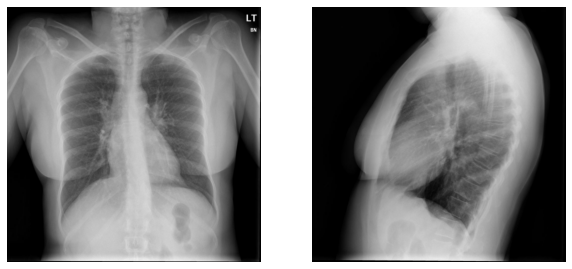


True caption: 'no acute cardiopulmonary abnormality . .'
Predicted through Greedy Method: 'no acute cardiopulmonary abnormality .'




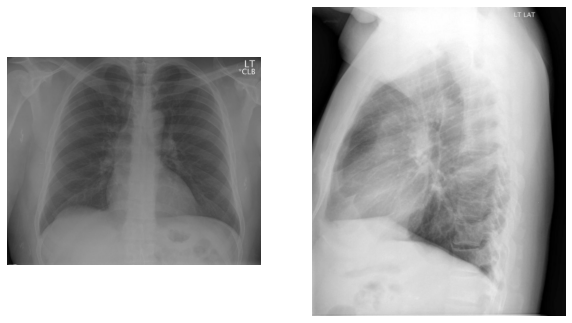


True caption: 'no acute cardiopulmonary abnormality .'
Predicted through Greedy Method: 'no acute cardiopulmonary abnormality .'




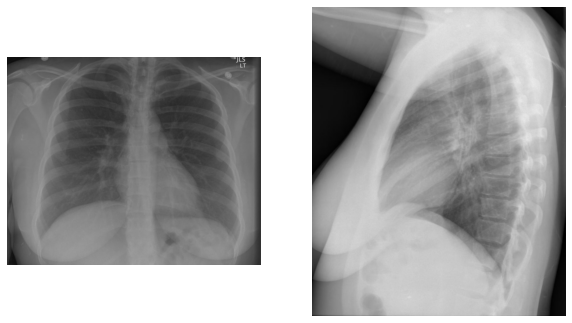


True caption: 'no acute cardiopulmonary abnormality .'
Predicted through Greedy Method: 'no acute cardiopulmonary abnormality .'




In [ ]:
sample = test1[(test1['BLEU Score']>0.75)].sample(3).index
for _,p in enumerate(sample):
  image1,image2 = test1['image_1'][p],test1['image_2'][p]
  true = test1['impression'][p]
  
  image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
  image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
  Greedy_Predicted = Greedy_Search(image1,image2,model1)
  plt.figure(figsize = (10,20))
  plt.subplot(121)
  plt.imshow(image1_array)
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(image2_array)
  plt.axis("off")
  plt.show()

  print("\nTrue caption: '%s'"%(true))
  print("Predicted through Greedy Method: '%s'"%(Greedy_Predicted))
  print("\n")